In [1]:
#-*- coding:utf8 -*-
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [2]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [3]:
def build_dataset():
    X_features = ['temperature.SI','pressure.SI','humidity.SI','wind_speed.SI','PM2.5.SI','NO2.SI','CO.SI','O3.SI','SO2.SI']
    Y_features = ['PM2.5.SI']
    dfx = pd.read_csv('../xs.csv')
    dfy = pd.read_csv('../ys.csv')   
    X = dfx[X_features].values.astype(np.float32)
    Y = dfy[Y_features].values.astype(np.float32)
    return X, Y

x_vals, y_vals = build_dataset()
print 'Shape of X: ', x_vals.shape, 'Shape of Y', y_vals.shape

Shape of X:  (131730, 9) Shape of Y (131730, 1)


## 数据预处理

In [4]:
# Create graph session
sess = tf.InteractiveSession()

# set batch size for training
batch_size = 10000

# make results reproducible
seed = 3
np.random.seed(seed)
tf.set_random_seed(seed)

# 将所有数据分割成训练集80%测试集20%
train_indices = np.random.choice(len(x_vals), int(round(len(x_vals)*0.8)), replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))

x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

#### *原始数据存储*

In [5]:
def save_data(x_vals, y_vals, file_name, y_label):
    # save train data
    temp_data = pd.DataFrame(x_vals, columns=['temperature.SI','pressure.SI','humidity.SI','wind_speed.SI','PM2.5.SI','NO2.SI','CO.SI','O3.SI','SO2.SI'])
    temp_data[y_label] = y_vals
    temp_data.to_csv(file_name, index=False)
    return 

In [6]:
y_label = 'y_'+'SO2.SI'
# save train data
train_file = './data/SO2_train.csv'
save_data(x_vals_train, y_vals_train, train_file, y_label)
# save test data
test_file = './data/SO2_test.csv'
save_data(x_vals_test, y_vals_test, test_file, y_label)

## 构建网络

In [7]:
# 定义变量函数(权重和偏差)，stdev参数表示方差
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return (weight)


def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return (bias)

# 创建一个全连接层函数
def fully_connected(input_layer, weights, biases, activation=True):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    if(activation):
        return (tf.nn.sigmoid(layer))
    else:
        return (layer)

# 创建数据占位符
x_data = tf.placeholder(shape=[None, 9], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# layer0->layer1 （9，7）
W_0 = init_weight(shape=[9, 40], st_dev=10.0)
b_0 = init_bias(shape=[40], st_dev=10.0)
layer_1 = fully_connected(x_data, W_0, b_0)

# layer1->layer2 （7，10）
W_1 = init_weight(shape=[40, 40], st_dev=10.0)
b_1 = init_bias(shape=[40], st_dev=10.0)
layer_2 = fully_connected(layer_1, W_1, b_1)

# layer2->output （10，1）
W_2 = init_weight(shape=[40, 40], st_dev=10.0)
b_2 = init_bias(shape=[40], st_dev=10.0)
layer_3 = fully_connected(layer_2, W_2, b_2)

W_3 = init_weight(shape=[40, 1], st_dev=10.0)
b_3 = init_bias(shape=[1], st_dev=10.0)
layer_out = fully_connected(layer_3, W_3, b_3, False)

# 交叉熵函数
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=layer_out, labels=y_target))

# 定义优化器
my_opt = tf.train.AdamOptimizer(0.002)  # 使用Adam优化器，学习率使用0.002
train_step = my_opt.minimize(loss)


## 填充数据与训练

In [8]:
sess.run(tf.global_variables_initializer())

# def rmsle(y, y0):
#     assert len(y) == len(y0)
#     return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

# Actual Prediction
prediction = tf.round(tf.nn.sigmoid(layer_out))
rmsle = tf.sqrt(tf.reduce_mean(tf.pow(tf.log1p(y_target)-tf.log1p(prediction), 2)))

In [9]:
# 训练
loss_vec = []
train_rmsle = []
test_rmsle = []
for i in range(25000):
    rand_index = np.random.choice(len(x_vals_train), size=batch_size)
    rand_x = x_vals_train[rand_index]  # shape=[batch_size,7]
    rand_y = y_vals_train[rand_index].reshape([batch_size, 1])
    # 使用训练数据对网络进行训练
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})

    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    temp_rmsle_train = sess.run(rmsle, feed_dict={x_data: x_vals_train, y_target: y_vals_train})
    train_rmsle.append(temp_rmsle_train)
    temp_rmsle_test = sess.run(rmsle, feed_dict={x_data: x_vals_test, y_target: y_vals_test})
    test_rmsle.append(temp_rmsle_test)
    if (i + 1)%1000 == 0:
        print('Generation: ' + str(i + 1) + '. Loss = ' + str(temp_loss))

Generation: 1000. Loss = 1.3090003
Generation: 2000. Loss = 0.80536395
Generation: 3000. Loss = 0.6725804
Generation: 4000. Loss = 0.58619356
Generation: 5000. Loss = 0.54901457
Generation: 6000. Loss = 0.5124794
Generation: 7000. Loss = 0.49372378
Generation: 8000. Loss = 0.47590548
Generation: 9000. Loss = 0.46486938
Generation: 10000. Loss = 0.4523773
Generation: 11000. Loss = 0.44902056
Generation: 12000. Loss = 0.43944395
Generation: 13000. Loss = 0.4345749
Generation: 14000. Loss = 0.43516308
Generation: 15000. Loss = 0.4312133
Generation: 16000. Loss = 0.4275261
Generation: 17000. Loss = 0.42161593
Generation: 18000. Loss = 0.42603818
Generation: 19000. Loss = 0.42102915
Generation: 20000. Loss = 0.42442983
Generation: 21000. Loss = 0.4244622
Generation: 22000. Loss = 0.42377388
Generation: 23000. Loss = 0.41961807
Generation: 24000. Loss = 0.41922998
Generation: 25000. Loss = 0.41525492


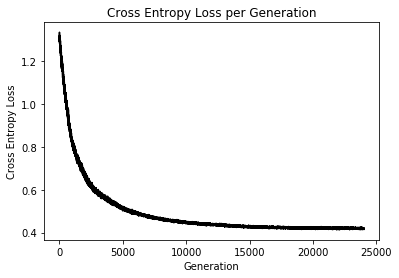

In [10]:
burnin = 1000
# Plot loss over time
plt.plot(loss_vec[burnin:], 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()

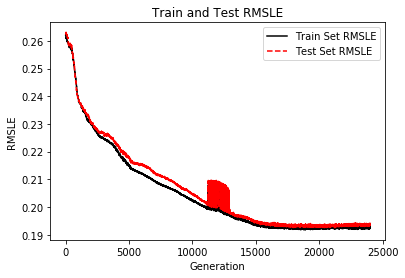

In [11]:
# Plot train and test accuracy
burnin = 1000
plt.plot(train_rmsle[burnin:], 'k-', label='Train Set RMSLE')
plt.plot(test_rmsle[burnin:], 'r--', label='Test Set RMSLE')
plt.title('Train and Test RMSLE')
plt.xlabel('Generation')
plt.ylabel('RMSLE')
plt.legend(loc='upper right')
plt.show()